## 라이브러리 임포트 

In [3]:
## library import - data preprocessing
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder

In [4]:
## BERT embedding 
from transformers import BertTokenizer, BertModel
import torch 

In [5]:
## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [6]:
## 평가 지표 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr

In [7]:
## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [8]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (윈도우용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [9]:
# tqdm 
from tqdm import tqdm 

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
# kaggle hub
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [12]:
## GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

사용 중인 디바이스: cuda


In [13]:
print("CUDA 사용 가능?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 중인 GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU를 사용할 수 없습니다.")


CUDA 사용 가능? True
사용 중인 GPU: NVIDIA GeForce MX450


## data load

In [15]:
# 파일 경로
file_path = r"C:\Users\wonny\OneDrive\문서\카카오톡 받은 파일\movie. 4000.csv"

# 데이터 로드
df = pd.read_csv(file_path)

In [16]:
# data 확인
df.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,thumbnail_link,date,keyword
0,8C8VO9KVxPM,Action film Boukary,Boukary Togo,22,[none],105031191,1168217,0,2004,https://i.ytimg.com/vi/8C8VO9KVxPM/default.jpg,4.09,action movie
1,eFteb0BjNKg,Funny iconic scenes from Jackie Chan’ movies #...,Dragonfly Movie,1,[none],70816357,1717044,0,4612,https://i.ytimg.com/vi/eFteb0BjNKg/default.jpg,1.12,action movie
2,RJ6vZQEWay4,Every little kid in an action movie,Howieazy,24,Shorts|Little kids in action movies|Action mov...,63500695,3155219,0,11304,https://i.ytimg.com/vi/RJ6vZQEWay4/default.jpg,22.09,action movie
3,iwQX9OYS9pQ,Ugram | ಉಗ್ರಂ || Kannada Full HD Movie || Sri ...,SRS Media Vision | Kannada Full Movies,1,Srimurali (Film Actor)|Haripriya (Film Actor)|...,57672374,357559,0,16111,https://i.ytimg.com/vi/iwQX9OYS9pQ/default.jpg,24.11,action movie
4,d4GyMKBm59U,Salaakhen {HD} - Hindi Full Movie - Sunny Deol...,Shemaroo Movies,1,Salaakhen|Salaakhen Full Movie|Anupam Kher Mov...,52317277,168896,0,5755,https://i.ytimg.com/vi/d4GyMKBm59U/default.jpg,27.04,action movie


In [17]:
# 데이터 확인 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850 entries, 0 to 3849
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        3850 non-null   object 
 1   title           3850 non-null   object 
 2   channel_title   3850 non-null   object 
 3   category_id     3850 non-null   int64  
 4   tags            3850 non-null   object 
 5   views           3850 non-null   int64  
 6   likes           3850 non-null   int64  
 7   dislikes        3850 non-null   int64  
 8   comment_count   3850 non-null   int64  
 9   thumbnail_link  3850 non-null   object 
 10  date            3850 non-null   float64
 11  keyword         3850 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 361.1+ KB


## data prepocessing

### target scaling

In [18]:
# 필요한 칼럼만 추출
df = df[['title', 'views']].copy()

Text(0, 0.5, 'Frequency')

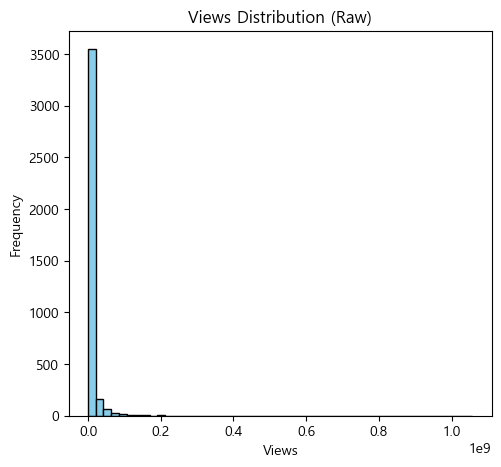

In [19]:
# 원본 분포
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['views'], bins=50, color='skyblue', edgecolor='black')
plt.title('Views Distribution (Raw)')
plt.xlabel('Views')
plt.ylabel('Frequency')

In [20]:
# target scaling
df['log_views'] = np.log1p(df['views'])

# scaler = StandardScaler()
# df['scaled_views'] = scaler.fit_transform(df[['log_views']])

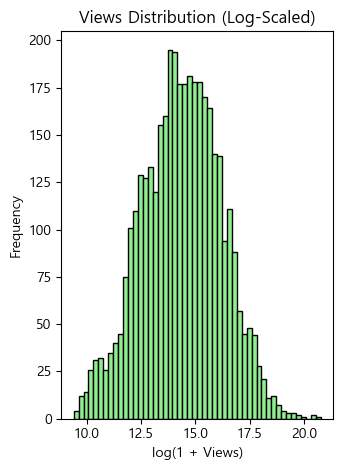

In [21]:
# 로그 변환 분포
plt.subplot(1, 2, 2)
plt.hist(df['log_views'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Views Distribution (Log-Scaled)')
plt.xlabel('log(1 + Views)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### BERT embedding

In [22]:
# BERT load 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
# BERT embedding extract 
## CLS 벡터 추출 함수 정의 
def extract_cls_embedding(text):
    encoding = tokenizer(text,
                         max_length=32,
                         truncation=True,
                         padding='max_length',
                         return_tensors='pt')
    input_ids_tensor = encoding['input_ids'].to(device)
    attention_mask_tensor = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

In [24]:
## 제목을 cls로 추출 
embeddings = np.array([
    extract_cls_embedding(title) for title in tqdm(df['title'])
])

100%|██████████████████████████████████████████████████████████████████████████████| 3850/3850 [04:43<00:00, 13.57it/s]


## Modeling

In [25]:
X = embeddings
y = df['log_views']

# test, train dataset 분리 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
# Model 성능 평가 함수 
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Spearman: {spearman_corr:.4f}")
    
    return model, rmse, r2, spearman_corr

In [27]:
# Lasso 모델 정의
alpha_value = 0.0001
lasso = Lasso(alpha=alpha_value)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# 성능 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: Lasso")
print("Alpha:", alpha_value)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장 
lasso_results_df = pd.DataFrame([{
    "Model": "Lasso",
    "Alpha": alpha_value,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

Model: Lasso
Alpha: 0.0001
RMSE: 1.6813
R²: 0.1119
Spearman: 0.4639


C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.597e+02, tolerance: 1.030e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Gaming - Linear Regression

In [28]:
# LinearRegression 모델 정의 및 학습
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

# 성능 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: LinearRegression")
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
linear_results_df = pd.DataFrame([{
    "Model": "LinearRegression",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

Model: LinearRegression
RMSE: 1.7116
R²: 0.0796
Spearman: 0.4531


C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### gaming - Ridge

In [29]:
# Ridge 모델 정의 및 학습
alpha_value = 1.0
ridge = Ridge(alpha=alpha_value)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# 성능 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: Ridge")
print("Alpha:", alpha_value)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
ridge_results_df = pd.DataFrame([{
    "Model": "Ridge",
    "Alpha": alpha_value,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Model: Ridge
Alpha: 1.0
RMSE: 1.6549
R²: 0.1396
Spearman: 0.4715


C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### gaming - RF 

In [30]:
# RF 모델 정의 및 학습
n_estimators = 100
rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# 성능 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: RandomForest")
print("n_estimators:", n_estimators)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
rf_results_df = pd.DataFrame([{
    "Model": "RandomForest",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Model: RandomForest
n_estimators: 100
RMSE: 1.5071
R²: 0.2864
Spearman: 0.5214


C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### gaming - Gradient 

In [31]:
# Gradient Boosting 모델 정의 및 학습
n_estimators = 100
gbr = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

# 성능 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: GradientBoosting")
print("n_estimators:", n_estimators)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
gbr_results_df = pd.DataFrame([{
    "Model": "GradientBoosting",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Model: GradientBoosting
n_estimators: 100
RMSE: 1.5375
R²: 0.2573
Spearman: 0.4918


C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
# 모델별 결과 DataFrame 합치기
all_results = pd.concat([
    lasso_results_df,
    ridge_results_df,
    rf_results_df,
    gbr_results_df
], ignore_index=True)


C:\Users\wonny\AppData\Local\Temp\ipykernel_740\1629461833.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([


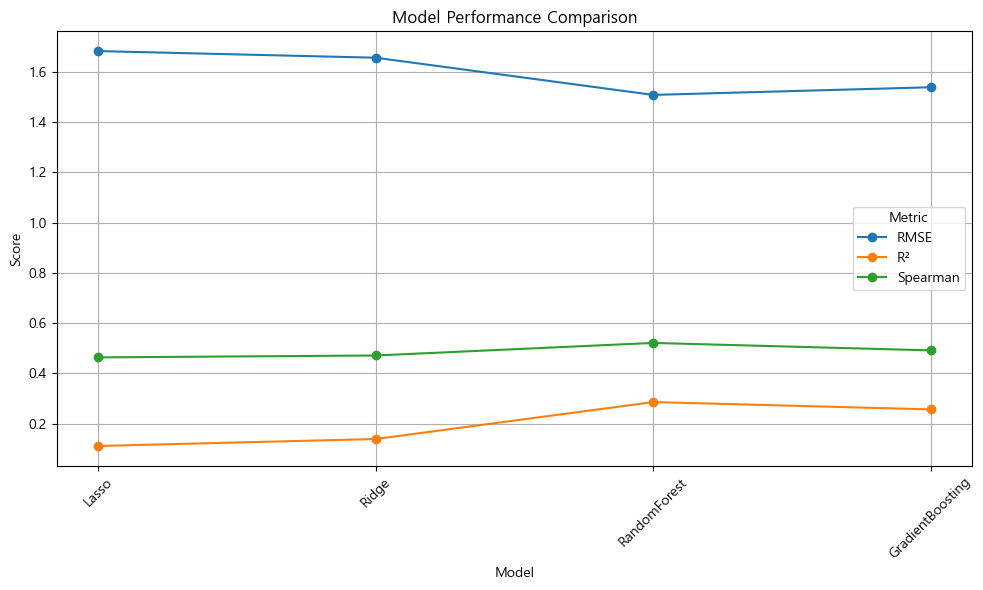

In [33]:
# 시각화를 위한 변환 (wide → long)
results_long = all_results.melt(
    id_vars="Model", 
    value_vars=["RMSE", "R²", "Spearman"],
    var_name="Metric", 
    value_name="Score"
)

# 선 그래프(line chart)로 시각화
plt.figure(figsize=(10, 6))
for metric in results_long["Metric"].unique():
    subset = results_long[results_long["Metric"] == metric]
    plt.plot(subset["Model"], subset["Score"], marker='o', label=metric)

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
all_results

,Model,Alpha,RMSE,R²,Spearman
0,Lasso,0.0001,1.681277,0.111904,0.463910
1,Ridge,1.0000,1.654887,0.139565,0.471524
2,RandomForest,NaN,1.507121,0.286363,0.521442
3,GradientBoosting,NaN,1.537484,0.257319,0.491823
